In [137]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

In [183]:
from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
print(__doc__)

Automatically created module for IPython interactive environment


In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [5]:
# download data

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [6]:
n_samples, h, w = lfw_people.images.shape
print(n_samples, h, w)

1288 50 37


In [9]:
X = lfw_people.data
n_features = X.shape[1]
print(X.shape)

(1288, 1850)


In [124]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(f"Target names: {target_names}")
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [12]:
%%time

n_components = 150
print(f"Extracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)

Extracting the top 150 eigenfaces from 966 faces
CPU times: user 261 ms, sys: 115 ms, total: 376 ms
Wall time: 109 ms


Text(0, 0.5, 'Explained Variance Ratio\n(accumulated)')

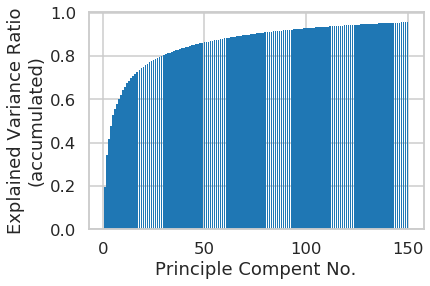

In [187]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.bar(np.arange(len(cumsum))+1, cumsum, ec='none')
ax.set_xlabel("Principle Compent No.")
ax.set_ylabel("Explained Variance Ratio\n(accumulated)")

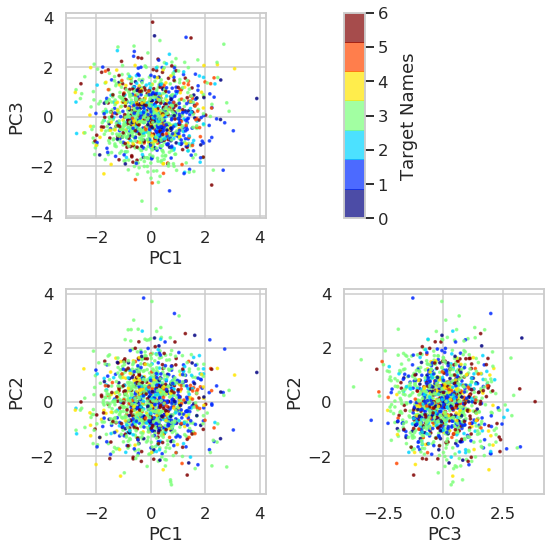

In [190]:
X_transformed = pca.transform(X)
PC1 = X_transformed[:, 0]
PC2 = X_transformed[:, 1]
PC3 = X_transformed[:, 2]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
im = ax[0][0].scatter(PC1, PC3, c=y, cmap=plt.cm.get_cmap("jet", len(target_names)), s=5, alpha=0.7)
ax[1][0].scatter(PC1, PC2, c=y, cmap=plt.cm.jet, s=5, alpha=0.7)
ax[1][1].scatter(PC3, PC2, c=y, cmap=plt.cm.jet, s=5, alpha=0.7)

ax[0][0].set_xlabel("PC1")
ax[0][0].set_ylabel("PC3")

ax[1][0].set_xlabel("PC1")
ax[1][0].set_ylabel("PC2")

ax[1][1].set_xlabel("PC3")
ax[1][1].set_ylabel("PC2")

ax[0][1].axis("off")

cbar = plt.colorbar(im, ax=ax[0][1], ticks=np.arange(len(target_names)), 
                    drawedges=False, fraction=1, aspect=10)
cbar.set_label("Target Names", labelpad=12)

fig.tight_layout()

In [133]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [14]:
%%time
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

CPU times: user 33.2 ms, sys: 0 ns, total: 33.2 ms
Wall time: 10.5 ms


In [34]:
C = [1e3, 5e3, 1e4, 5e4, 1e5]
gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

In [15]:
%%time
param_grid = {"C": C, "gamma": gamma}
clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(X_train_pca, y_train)

print(f"Best estimator found by grid search: {clf.best_estimator_}")

Best estimator found by grid search: SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
CPU times: user 35.4 s, sys: 0 ns, total: 35.4 s
Wall time: 35.4 s


In [85]:
df_cv_result = pd.DataFrame({"gamma": clf.cv_results_['param_gamma'].data,
                             "C": clf.cv_results_['param_C'].data,
                             "mean_test_score": clf.cv_results_['mean_test_score'],
                             "rank_test_score": clf.cv_results_['rank_test_score']
                            })
df_cv_result

,gamma,C,mean_test_score,rank_test_score
0,0.0001,1000,0.751589,20
1,0.0005,1000,0.779504,11
2,0.001,1000,0.785717,6
3,0.005,1000,0.795032,1
4,0.01,1000,0.678062,21
5,0.1,1000,0.397516,26
6,0.0001,5000,0.755729,16
7,0.0005,5000,0.779504,11
8,0.001,5000,0.785717,6
9,0.005,5000,0.795032,1


In [84]:
df_cv_result.sort_values(by=["gamma", "C"])

,gamma,C,mean_test_score,rank_test_score
0,0.0001,1000,0.751589,20
6,0.0001,5000,0.755729,16
12,0.0001,10000,0.755729,16
18,0.0001,50000,0.755729,16
24,0.0001,100000,0.755729,16
1,0.0005,1000,0.779504,11
7,0.0005,5000,0.779504,11
13,0.0005,10000,0.779504,11
19,0.0005,50000,0.779504,11
25,0.0005,100000,0.779504,11


In [110]:
df_cv_result.sort_values(by=["gamma", "C"], inplace=True)
df_cv_result.reset_index(drop=True)

,gamma,C,mean_test_score,rank_test_score
0,0.0001,1000,0.751589,20
1,0.0001,5000,0.755729,16
2,0.0001,10000,0.755729,16
3,0.0001,50000,0.755729,16
4,0.0001,100000,0.755729,16
5,0.0005,1000,0.779504,11
6,0.0005,5000,0.779504,11
7,0.0005,10000,0.779504,11
8,0.0005,50000,0.779504,11
9,0.0005,100000,0.779504,11


In [111]:
df_cv_result_pivot = df_cv_result.pivot("gamma", "C")
df_cv_result_pivot

mean_test_score                                          \
C             1000.0    5000.0    10000.0   50000.0   100000.0   
gamma                                                            
0.0001        0.751589  0.755729  0.755729  0.755729  0.755729   
0.0005        0.779504  0.779504  0.779504  0.779504  0.779504   
0.0010        0.785717  0.785717  0.785717  0.785717  0.785717   
0.0050        0.795032  0.795032  0.795032  0.795032  0.795032   
0.0100        0.678062  0.678062  0.678062  0.678062  0.678062   
0.1000        0.397516  0.397516  0.397516  0.397516  0.397516   

       rank_test_score                                      
C             1000.0   5000.0   10000.0  50000.0  100000.0  
gamma                                                       
0.0001              20       16       16       16       16  
0.0005              11       11       11       11       11  
0.0010               6        6        6        6        6  
0.0050               1        1        1        1        1  
0.0100              21       21       21       21       21  
0.1000              26       26       26       26       26

In [116]:
C = df_cv_result_pivot.columns.levels[1].values
gamma = df_cv_result_pivot.index.values
cv_score = df_cv_result_pivot["mean_test_score"].values

Ci, gammai = np.meshgrid(C, gamma)

In [118]:
df_cv_result_pivot["mean_test_score"]

C,1000.0,5000.0,10000.0,50000.0,100000.0
gamma,,,,,
0.0001,0.751589,0.755729,0.755729,0.755729,0.755729
0.0005,0.779504,0.779504,0.779504,0.779504,0.779504
0.0010,0.785717,0.785717,0.785717,0.785717,0.785717
0.0050,0.795032,0.795032,0.795032,0.795032,0.795032
0.0100,0.678062,0.678062,0.678062,0.678062,0.678062
0.1000,0.397516,0.397516,0.397516,0.397516,0.397516


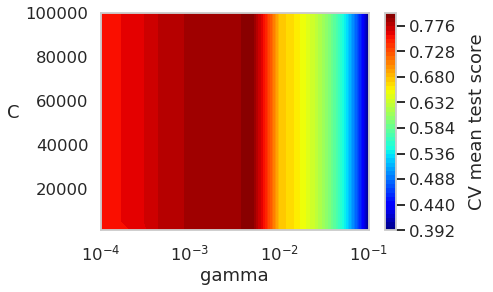

In [195]:
fig, ax = plt.subplots()

im = ax.contourf(gammai, Ci, cv_score, cmap=plt.cm.jet, levels=50)
ax.set_xscale("log")
ax.set_xlabel("gamma")
ax.set_ylabel("C", rotation=0, labelpad=12)
cbar = plt.colorbar(im)
cbar.set_label("CV mean test score", labelpad=12)
plt.show()

In [48]:
%%time
y_pred = clf.predict(X_test_pca)

CPU times: user 70.8 ms, sys: 0 ns, total: 70.8 ms
Wall time: 67.6 ms


In [68]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.87      0.83        60
  Donald Rumsfeld       0.89      0.63      0.74        27
    George W Bush       0.84      0.98      0.91       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.83      0.90        36

         accuracy                           0.86       322
        macro avg       0.89      0.73      0.79       322
     weighted avg       0.86      0.86      0.85       322



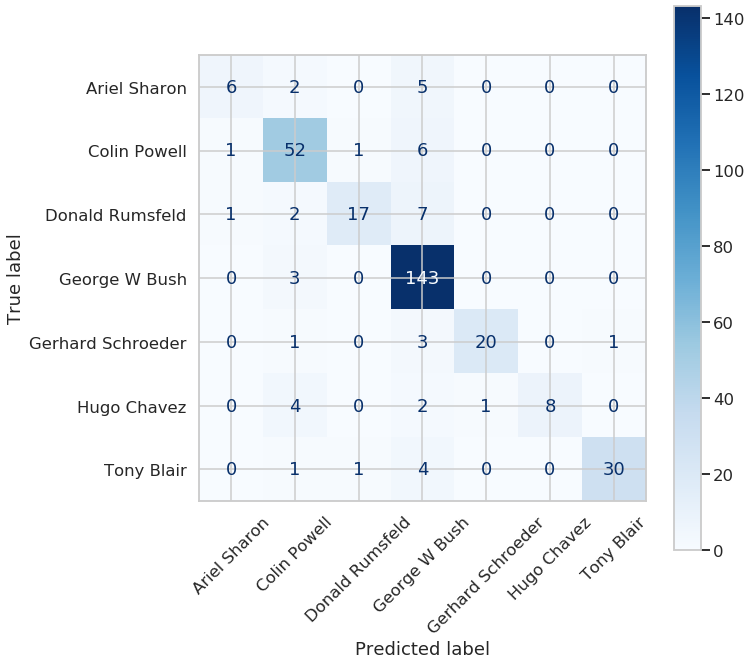

In [196]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(clf, X_test_pca, y_test,
                             display_labels = target_names,
                             cmap = plt.cm.Blues, 
                             values_format = ".0f",
                             ax=ax
                            )
ax.set_xticklabels(target_names, rotation=45)
plt.show()

In [134]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8*n_col, 2.4*n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return f"predicted: {pred_name}\ntrue:      {true_name}"

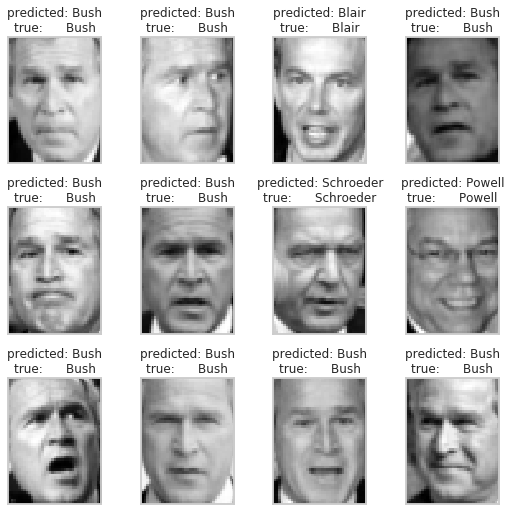

In [197]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

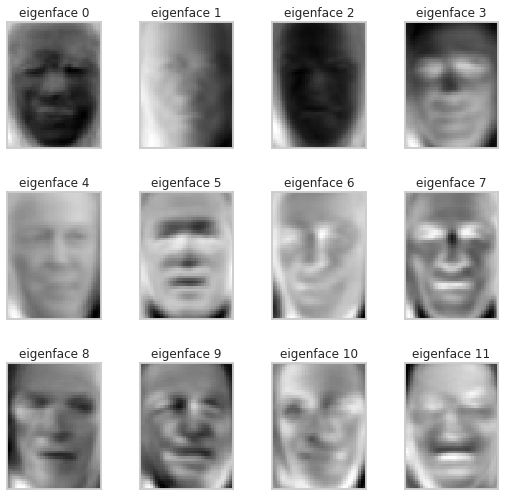

In [198]:
eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()